# Physics 453: Finite Spherical Well

You've learned about how to solve the Schrodinger equation in 3 dimensions for spherically symmetric potentials, $V(\vec{r})=V(r)$, by using spherical coordinates and searching for a separable solution. As shown in Chapter 4 of Griffiths, the anugular part of the solution does not depend on the details of the solutions, and is given by one of the *spherical harmonics*.  The real problem is to solve the *radial equation*, which when we switch variables to $u(r)=rR(r)$ is given by:
$$-\frac{\hbar^2}{2m} \frac{d^2u}{dr^2}+\left[ V(r)+\frac{\hbar^2}{2m}\frac{l(l+1)}{r^2}\right]u=Eu$$

Where $k=\sqrt{(E-V)2m}/\hbar$. As noted by Equation [4.45] in Griffiths, the general solution to this equation when $V(R)=V$ is constant is
$$ u(r)=Arj_l(kr)+Brn_l(kr)$$
where $j_l(x)$ is the spherical Bessel function (of the first kind) of order $l$ and $n_l(x)$ is the spherical Neumann function (or Bessel function of the second kind) of order $l$. When we are looking for the solution is a region of space where the wavefunction should decay (ie, $E<V$), then we should use Hankel functions, which are just linear combinations of the Bessel and Neumann functions. See the first Reference for more about Hankel functions.

### References
More about choosing the right special functions for each region: http://quantummechanics.ucsd.edu/ph130a/130_notes/node225.html

How to get Bessel, Hankel, etc. functions (and their derivatives!) in Python: https://docs.scipy.org/doc/scipy/reference/special.html

How to use brentq from SciPy: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.brentq.html

### Finite Spherical Well
In this notebook you are going to find the bound state solutions to the finite spherical well for arbitrary $l$.  The potential is given by $V(r)=-|V|$ for $r<=a$, and $V(r)=0$ for $r>a$.  Applying the wavefunction boundary conditions at $r=a$ will result in a transcendental equation, which we need to solve numerically.

We will use the following parameters:
$$\hbar=m=1$$
$$a=2$$
$$V=-10$$

#### Question 1
The first step is to derive the transcendental equation the arises from the boundary conditions for the finite spherical well.  Do this on paper and hand in the paper!  Also, write the transcendental equation you found in the box below.

*Write your result here!*

$$ k_1\frac{j_l^\prime(z=k_1a)}{j_l(z=k_1a)}=ik_2\frac{h_l^\prime(z=k_2a)}{h_l(z=k_2a)}$$
$$k_1=\sqrt{2m(E-V)}/\hbar$$
$$k_2=\sqrt{2m|E|}/\hbar$$

Now let's get to coding.  First we'll load the libraries we'll need.

In [1]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt 
import numpy
import scipy.special    #Contains the bessel, neumann, and hankel function methods
import scipy.optimize   #Contains brentq, the root finding algorithm we'll use

In [2]:
hbar=1
m=1
a=2
V=-10

#### Question 2

Let's get comfortable with using the special function methods from scipy.  Make a plot of the $l=0,1,2$ Bessel functions (of the first kind) *and* their derivatives over $x=0..10$. (Hint: Take a look at the second reference.)

<IPython.core.display.Javascript object>


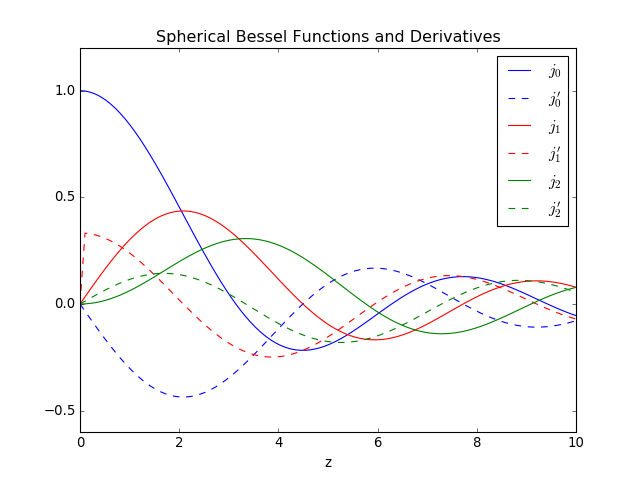

In [3]:
#Make a plot!
#Practice using the scipy special function methods for spherical Bessel functions
N=100
z = numpy.linspace(0, 10, N)
colors = ['blue','red','green']

for i in [0,1,2]:
    plt.plot(z, scipy.special.spherical_jn(i,z),color=colors[i], label=r'$j_'+str(i)+'$')
    plt.plot(z, scipy.special.spherical_jn(i,z,True),'--',color=colors[i], label=r'$j^\prime_'+str(i)+'$')
plt.xlabel("z")
plt.title("Spherical Bessel Functions and Derivatives")
plt.legend()
plt.show()

#### Question 3
The transcendental equation you derived should have the form:
$$f_l(E) = g_l(E)$$
The energies, $E$, that satisfy this equation (for the given angular momentum $l$) are the bound state energies.  Alternatively, we can form a new function:
$$Q_l(E) = f_l(E)-g_l(E)$$
Now the energies that we seek are the roots of $Q_l(E)$, ie. $Q_l(E)=0$.

Write a function, called *boundary_function*, that takes $E$ and $l$ as arguments and returns the value of $Q_l(E)$. (You may also want to write short helper functions that calculate the value of $k$ in either region.)

Then make a plot of $Q_{l=0}(E)$ for $E=-|V|..0$.  Does $Q_l$ have an imaginary part?  How many bound states are there for $l=0$, and what are their approximate energies?  Note: you may get some error messages below the plot about dividing by zero.  Don't worry about them, they are just the result of trying to plot where the curve blows up to positive or negative infinity.

<IPython.core.display.Javascript object>


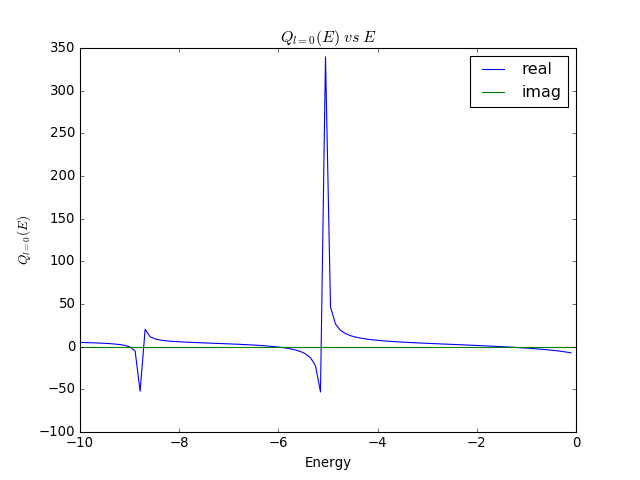

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in true_divide


In [6]:
#Fix these three functions
def k1(E):
    return numpy.sqrt((E-V)*2*m)/hbar

def k2(E):
    return numpy.sqrt(abs(E)*2*m)/hbar

def hankel(l, z):
    return numpy.sqrt(numpy.pi/(2*z))*scipy.special.h1vp(l+0.5,z,0)
    #return numpy.sqrt(numpy.pi/(2*z))*( scipy.special.jvp(l+0.5,z,n) + 1j*scipy.special.yvp(l+0.5,z,n) )
    
def hankel_deriv(l, z):
    return numpy.sqrt(numpy.pi/(2*z))*scipy.special.h1vp(l+0.5,z,1) - 0.5*(1./z)*numpy.sqrt(numpy.pi/(2*z))*scipy.special.h1vp(l+0.5,z,0)
    
#transcendental equation arising from matching boundary conditions for finite spherical well
def boundary_function(E, l):
    
    left = k1(E)*scipy.special.spherical_jn(l, k1(E)*a, 1)/scipy.special.spherical_jn(l, k1(E)*a, 0)
    #right = 1j*k2(E)*hankel(l, 1j*k2(E)*a, 1)/hankel(l, 1j*k2(E)*a, 0)
    right = 1j*k2(E)*hankel_deriv(l, 1j*k2(E)*a)/hankel(l, 1j*k2(E)*a)
    
    return (left-right).real


#Make a plot
#Plot the transcendental equation arising from the boundary conditions
#Zeroes of this function are physical energy solutions

plt.figure()
energies = numpy.linspace(V, 0, 100)
fnc = boundary_function(energies, 0)

plt.plot(energies, fnc.real, label="real")
plt.plot(energies, fnc.imag, label="imag")
plt.xlabel('Energy')
plt.ylabel(r'$Q_{l=0}(E)$')
plt.title(r'$Q_{l=0}(E)\; vs\; E$')
plt.legend()
plt.show()

*Write the written part of the answer here*

$Q_{l=0}$ does not appear to have an imaginary part and there are three zero crossings, indicating that there are three bound states.  They approximately occur at $E=-9,-6,-1.4$.

#### Question 4
You should have seen that $Q_l(E)$ is a purely real function, so modify your function to return only the real part. (Note: probably you'll see a very small imaginary part; this is due to numerical error, and is why we need to explicitly return the real part.)

You can eyeball the energies from the plot, but we want to do better than that.  We'll start off by writing a function that takes a range of energies and return a list of pairs of energies, $(E-dE, E)$, between which there is a zero of $Q_l(E)$ (or equivalently, between which $Q_l(E)$ changes sign).  Do the results for $l=0$ seem to agree with your plot?

In [7]:
#Implement this function!
def acquire_zero_bounds(energy_range, l): 
    zeros_list=[]  #Add energy pairs to list list if we think there is a zero in between them
    value = boundary_function(energy_range[0],l)  #Get the starting value of boundary_function
    
    for i in range(0, len(energy_range)-1):
        new_value = boundary_function(energy_range[i+1],l)
        #If we crossed through a zero, save this pair of energies, but also make sure 
        #we are not at a place where the function is actually blowing up
        if(numpy.sign(new_value)*numpy.sign(value) == -1 and abs(value) < 1):
            zeros_list.append((energy_range[i], energy_range[i+1]))
        value = new_value
    return zeros_list

#Sweep through energies in steps on dE, starting from the lowest possible energy (V=-|V|) to the highest (0)
dE = abs(V)/1000
energy_range = numpy.arange(V, 0, dE)

#Finding solutions of this angular momentum quantum number, l
l=0

energy_bounds = acquire_zero_bounds(energy_range, l)
print(energy_bounds)


[(-9.0100000000000211, -9.0000000000000213), (-6.0800000000000836, -6.0700000000000838), (-1.5000000000001812, -1.4900000000001814)]


#### Question 5
Now we know the correct energies to within a small $\Delta E$. Now we can use a very nice root finding algorithm, called *brentq*, to find the zero to a very high degree of accuracy.  All the algorithm needs is the function, any extra arguments that it takes, and a sign-changing interval (which we just found!)

Use SciPy's brentq method to find the (numerically) exact bound state energies.

In [8]:
def acquire_energies(energy_bounds, l):
    energies = []
    for energy_bound in energy_bounds:
        energies.append( scipy.optimize.brentq(boundary_function, energy_bound[0], energy_bound[1], l) ) #What should the arguments be?
    return energies

energies = acquire_energies(energy_bounds, l)
print(energies)

[-9.005423248438039, -6.071859642187186, -1.4912503282431986]


#### Question 6
Now that we have the right energies, we need to construct the wavefunctions.  Write a function that takes the energies, a list of radii (positions), and the value of $l$ and returns a list of the wavefunctions for the possible bound states.  Also write a function that properly normalizes the wavefunction. (Remember that this is a radial wavefunction is spherical coordinates, so the norm looks a bit diferent!)  

In [9]:
#Plot each solution found for the given l
dr=0.01
max_r = 6
space = numpy.arange(0, max_r, dr)
inner = space <= a
outer = space > a

#Normalize the radial part of the wavefunction - Remember the r^2!
def normalize(psi, space, dr):
    norm = numpy.sum(numpy.conjugate(psi)*psi*space*space) * dr
    return psi / numpy.sqrt(norm)

def get_wavefunctions(space, energies, l):
    psis=[]
    for energy in energies:

        psi = numpy.zeros(len(space), complex)
        #How do we calcualte psi?
        A = hankel(l, 1j*k2(energy)*a) / scipy.special.spherical_jn(l, k1(energy)*a, 0)
    
        psi[inner] = A*scipy.special.spherical_jn(l, k1(energy)*space, 0)[inner]  #Examples of array masking
        psi[outer] = hankel(l, 1j*k2(energy)*space)[outer]
        
        psis.append(normalize(psi,space,dr))
        
    return psis


#### Question 7
Make a plot of the radial probability distribution, $RPD$, for all bound states for $l=0$.  Then make an energy level diagram for all bound state energies for $l=0,1,2$.  (Color code the lines based on $l$.)
$$RPD = |R|^2r^2$$

<IPython.core.display.Javascript object>


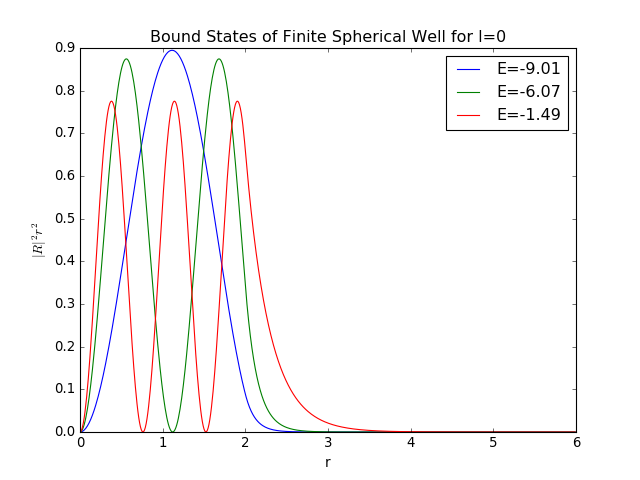

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>


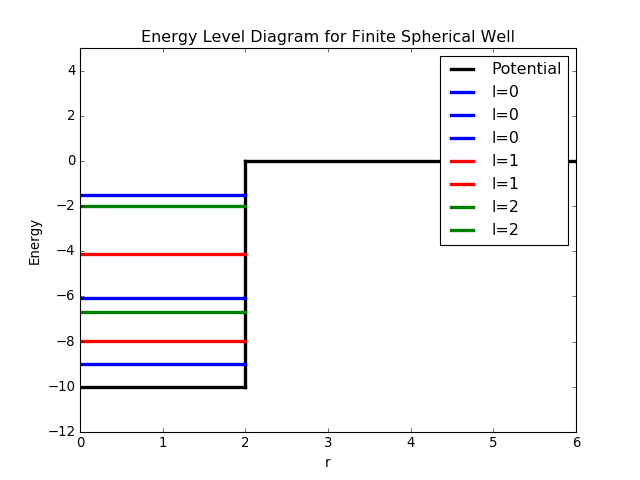

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in double_scalars


In [10]:
# Get all the bound state wavefunctions for l=0 and plot them
plt.figure()

wavefunctions = get_wavefunctions(space, energies, l)
for i in range(0,len(wavefunctions)):
    plt.plot(space, (numpy.conjugate(wavefunctions[i])*wavefunctions[i]*space*space).real, label="E="+str("%.2f" % energies[i]))
    
plt.xlabel('r')
plt.ylabel(r'$|R|^2r^2$')
plt.title('Bound States of Finite Spherical Well for l='+str(l))
plt.legend()
plt.show()


#Make an energy level diagram for l=0,1,2.  I've already started by drawing the potential, just draw the energy levels on top of it.
plt.figure()
plt.plot([0,a],[V,V],'k', lw=3, label="Potential")
plt.plot([a,a],[V,0],'k', lw=3)
plt.plot([a,max_r],[0,0], 'k', lw=3)

colors = ['blue','red', 'green', 'purple', 'orange']
for l_new in [0,1,2]:
    bounds_new = acquire_zero_bounds(energy_range, l_new)
    energies_new = acquire_energies(bounds_new, l_new)
    for energy in energies_new:
        plt.plot([0,a],[energy,energy], color=colors[l_new], lw=3, label="l="+str(l_new))

plt.legend()
plt.title('Energy Level Diagram for Finite Spherical Well')
plt.xlabel('r')
plt.ylabel('Energy')
plt.ylim([-12,5])
plt.show()